In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Dufrex'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

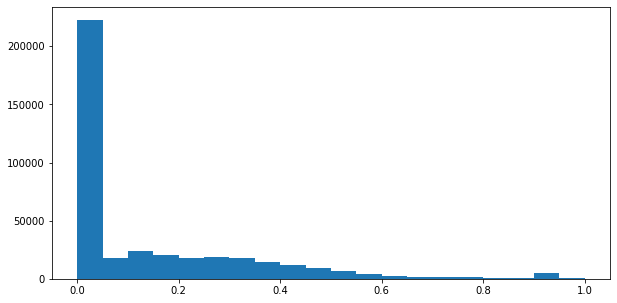

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

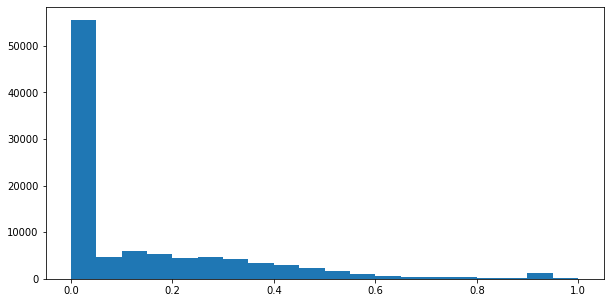

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'sigmoid'))
x.add(Dense(1024, activation = 'sigmoid'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         7755776     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 18s 22ms/step - loss: -0.4727 - manh_dist_loss: 0.0413 - abs_vect_loss: -0.9868 - abs_vect_1_loss: -0.9868 - manh_dist_rmse: 0.2032 - manh_dist_mae: 0.1324 - val_loss: -0.4854 - val_manh_dist_loss: 0.0212 - val_abs_vect_loss: -0.9921 - val_abs_vect_1_loss: -0.9920 - val_manh_dist_rmse: 0.1456 - val_manh_dist_mae: 0.1052
Epoch 2/20
781/781 [==============================] - 15s 19ms/step - loss: -0.4878 - manh_dist_loss: 0.0172 - abs_vect_loss: -0.9929 - abs_vect_1_loss: -0.9926 - manh_dist_rmse: 0.1310 - manh_dist_mae: 0.0961 - val_loss: -0.4894 - val_manh_dist_loss: 0.0133 - val_abs_vect_loss: -0.9923 - val_abs_vect_1_loss: -0.9918 - val_manh_dist_rmse: 0.1153 - val_manh_dist_mae: 0.0857
Epoch 3/20
781/781 [==============================] - 15s 19ms/step - loss: -0.4905 - manh_dist_loss: 0.0129 - abs_vect_loss: -0.9941 - abs_vect_1_loss: -0.9938 - manh_dist_rmse: 0.1135 - manh_dist_mae: 0.0858 - val_loss: -0.4909 - val_manh_dist_lo

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

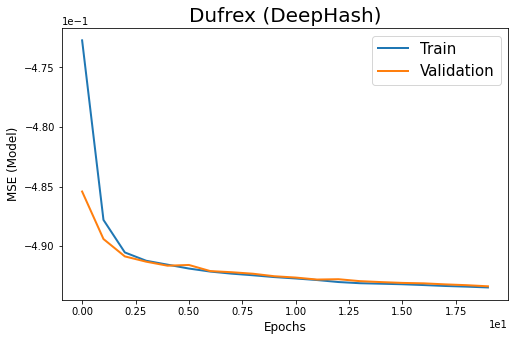

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Dufrex (Baseline)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Similarity preserving loss

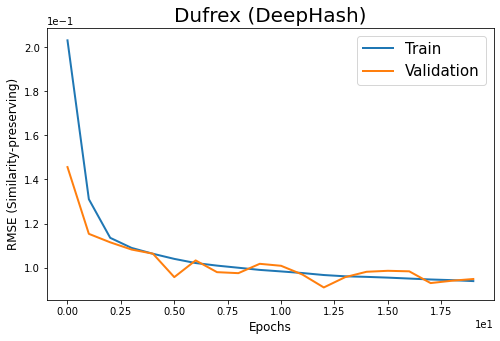

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Dufrex (Baseline)', fontsize = 20)
plt.ylabel('RMSE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

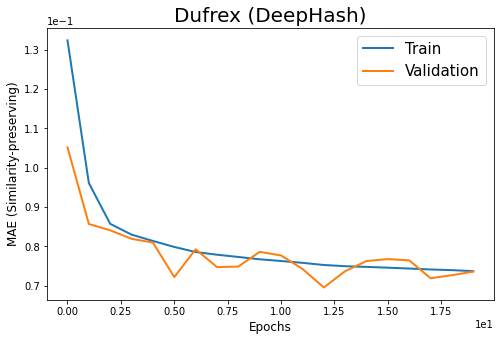

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Dufrex (Baseline)', fontsize = 20)
plt.ylabel('MAE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.04 , 0.12 , 0.029, 0.308, 0.054, 0.105, 0.465, 0.066, 0.4  ,
       0.044, 0.053, 0.098, 0.92 , 0.095, 0.063, 0.372, 0.357, 0.177,
       0.511, 0.065, 0.404, 0.284, 0.039, 0.09 , 0.14 , 0.05 , 0.117,
       0.209, 0.04 , 0.547, 0.086, 0.095, 0.118, 0.06 , 0.094, 0.031,
       0.085, 0.067, 0.027, 0.051, 0.508, 0.395, 0.074, 0.404, 0.077,
       0.276, 0.088, 0.225, 0.057, 0.077], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.034, 0.   , 0.367, 0.   , 0.   , 0.363, 0.   , 0.664,
       0.033, 0.   , 0.032, 0.905, 0.   , 0.   , 0.435, 0.225, 0.149,
       0.58 , 0.   , 0.331, 0.288, 0.022, 0.049, 0.172, 0.   , 0.114,
       0.14 , 0.   , 0.376, 0.011, 0.   , 0.024, 0.057, 0.09 , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.426, 0.413, 0.   , 0.341, 0.   ,
       0.136, 0.   , 0.256, 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

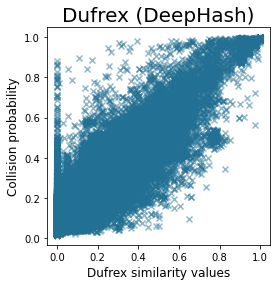

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Dufrex (Baseline)', fontsize = 20)
plt.xlabel("Dufrex similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/Dufrex-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.8555639168405658

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.7114765342230946

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-deep-hash.model/assets


In [ ]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [33]:
'First 64 bits'
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:64]

array([ 0.99999475,  0.99899876,  0.87596947,  0.9999965 ,  0.9997385 ,
       -0.9999622 , -0.9999847 ,  0.9999869 ,  0.9999896 ,  1.        ,
        0.9999922 , -0.99990904, -0.9997054 , -0.9982887 , -0.9999251 ,
       -0.99916685, -0.99994826, -0.9999985 , -0.9996777 , -0.99370193,
       -0.9998616 ,  0.9999992 , -0.9999619 ,  0.9998019 , -0.99897027,
       -0.9998364 , -0.9999864 ,  0.9973477 ,  0.9997484 ,  0.9941731 ,
        1.        , -0.9999718 , -0.9999995 , -0.99693376, -0.99998724,
        0.86684734, -0.9999994 , -1.        , -0.9995094 , -1.        ,
       -0.9999117 ,  1.        ,  0.9998478 ,  0.9999882 , -0.9999964 ,
       -0.9999189 , -0.9999535 ,  0.99971503, -0.9999575 ,  0.9999903 ,
       -0.99915946, -0.99997795,  0.9997697 ,  0.9998952 ,  0.9999112 ,
       -0.9999797 , -0.99987775,  0.99977833,  0.99999356, -0.9999989 ,
        0.9999802 ,  1.        , -0.99998754,  0.9999834 ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [34]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [35]:
np.mean(np.abs(hash_vectors))

0.898548

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [36]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.0592509765625

### 3.3.4. Comparison between approximate hamming and real hamming

In [37]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

In [38]:
df_hamming

,embedding_stack_1,embedding_stack_2,hamming
0,"[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1,...","[1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, ...",0.000000
1,"[1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1...","[1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, ...",0.031250
2,"[1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -...","[1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, ...",0.000000
3,"[1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -...","[1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, ...",0.156250
4,"[1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1...","[1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, ...",0.000000
...,...,...,...
99895,"[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1...","[1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1,...",0.000000
99896,"[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1...","[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1...",0.890625
99897,"[1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, ...","[1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, ...",0.000000
99898,"[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1...","[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1...",0.671875


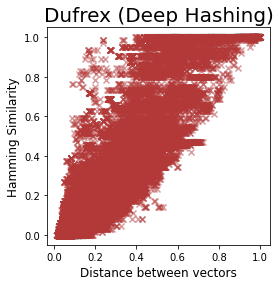

In [39]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Distance between vectors", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Dufrex (Deep Hashing)', fontsize = 20)
plt.savefig('Results/Baseline/Dufrex-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [40]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [41]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

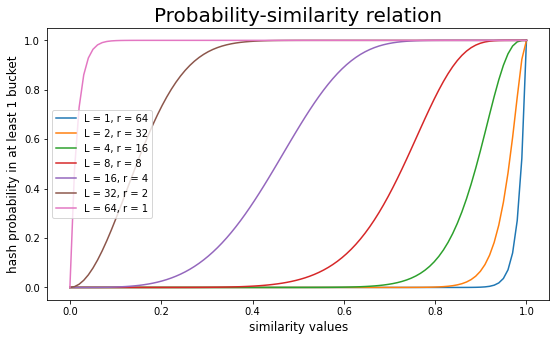

In [42]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 20)
plt.legend()

In [43]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Dufrex', trace = False)

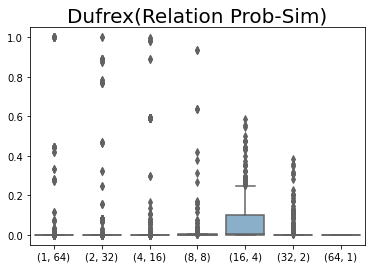

In [44]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.title('Dufrex(Relation Prob-Sim)', fontsize = 20)
plt.savefig('Results/Baseline/Dufrex-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [45]:
'L = K = 8'
L, K = params[2]
L, K

(4, 16)

### 4.1.1 Mean and Median probability for all stack traces for the best combination of $K$ and $L$

In [47]:
df_probLSH.mean()['(4, 16)']

0.07418622399722478

In [46]:
df_probLSH.median()['(4, 16)']

5.3145494893769296e-08

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [48]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [49]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [56]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

629

In [57]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{136, 172, 202, 429, 568, 629, 641, 648, 768}

In [58]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [59]:
near_duplicates_sim = df_measures['Dufrex'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

127176    0.931542
430883    0.910448
336964    0.910448
181923    0.885728
157578    0.748132
406464    0.423546
431003    0.298091
430876    0.293326
Name: Dufrex, dtype: float64

In [60]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Dufrex', n_stacks, n_duplicate_pairs)
set_real_nns

{34, 58, 136, 152, 172, 202, 429, 648}

In [61]:
real_nns_sim[:n_duplicate_pairs]

127176    0.931542
430883    0.910448
336964    0.910448
181923    0.885728
157578    0.748132
33999     0.548557
56859     0.545843
140848    0.545843
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [62]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Dufrex')

0.797

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Dufrex')

-----------------------------------------------------------------

In [63]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Dufrex')

0.7463333333333344

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Dufrex')

-----------------------------------------------------------------

In [64]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Dufrex')

0.7312000000000001

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Dufrex')

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [65]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.6366249726447095

In [66]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Dufrex', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.747363
(2, 32)    0.699179
(4, 16)    0.667012
(8, 8)     0.613017
(16, 4)    0.619083
(32, 2)    0.897891
(64, 1)    0.996243
dtype: float64

In [67]:
df_knns.mean()['(4, 16)']

0.6670115895207016